# SOFIA/FORCAST Galactic Center Photometry Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [36]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW', 'FieldA9', 'FieldB9', 'FieldC9', 'FieldF9', 'FieldI9', 'FieldL9', 'FieldN9']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [57]:
#import configuration for selected file
from config import FieldN9 as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [58]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table, join, vstack
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, EllipticalAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties

from regions import read_ds9

#removed...
#from photutils.psf import DAOGroup, IntegratedGaussianPRF
#from astropy.modeling.fitting import LevMarLSQFitter
#from photutils.psf import BasicPSFPhotometry
#from photutils.datasets import make_gaussian_sources_image
#from astropy.nddata import Cutout2D

In [59]:
def performApPhoto(data,tmap,wcs,sourceCoords,radii,rin,rout,plot=True):

	#create aperture objects for all specified radii 
	apertures =[SkyCircularAperture(sourceCoords, r=r*0.786*u.arcsec) for r in radii]

	#do aperture photometry on data using defined apertures 
	phot_table = aperture_photometry(data, apertures,wcs=wcs,error=errormap,method='exact')

	#now estimate local backgrounds using background annulus
	annulus_aperture = SkyCircularAnnulus(sourceCoords, r_in=rin*0.786*u.arcsec, r_out=rout*0.786*u.arcsec) #define annulus

	#convert to pixel coords for calcs and plotting
	pix_aperture = apertures[1].to_pixel(wcs) #only use one of the apertures for this. The default is the 2nd in the list
	pix_annulus_aperture = annulus_aperture.to_pixel(wcs)

	#store area value of annulus in case we want it later
	phot_table['pixAnnArea']=pix_annulus_aperture.area

    
	#now do robust statistics on the background annuli
	#create lists to store information for later
	bkg_median=[]
	bkg_mean=[]
	bkg_std=[]
	appmasks=[]

	#create mask array for the annuli
	annulus_masks = pix_annulus_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in annulus_masks:
		annulus_data = mask.multiply(data)
		maskdata=mask.data

		#do statistics
		annulus_data_1d = annulus_data[maskdata > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
		bkg_median.append(median_sigclip)
		bkg_mean.append(meansc)
		bkg_std.append(stdsc)
		appmasks.append(mask.data)

	#store values in numpy arrays
	bkg_median = np.array(bkg_median)
	bkg_mean = np.array(bkg_mean)
	bkg_std = np.array(bkg_std)

	#add columns for background information and also background subtracted apertures
	phot_table['ann_bkg_med'] = bkg_median
	phot_table['ann_bkg_mean'] = bkg_mean 
	phot_table['ann_bkg_std'] = bkg_std 


    
	#information from exposure time maps
	#create lists to store information for later
	texp_mean=[]
	texp_med=[]
	texpmasks=[]

	#create mask array for the exp time map apertures
	ap_masks = pix_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in ap_masks:
		ap_texp = mask.multiply(tmap)
        
		#do statistics
		ap_texp_1d = ap_texp[mask.data > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(ap_texp_1d)
		texp_med.append(median_sigclip)
		texp_mean.append(meansc)
		texpmasks.append(mask.data)

	phot_table['texp_med'] = texp_med
	phot_table['texp_mean'] = texp_mean
    


	#caclulate background subtracted photometry and snr for each source
	for i in range(0,len(radii)):
		#coloumn names and from the phot table and new columns we'll add
		cname1='aperture_sum_'+str(i)
		cname2='aperture_sum_err_'+str(i)
		newcol1='aper_sum_bkgsub_'+str(radii[i])+'pix'
		newcol2='aper_snr_'+str(radii[i])+'pix'
		newcol3='aper_area_'+str(radii[i])+'pix'
        
		#get pixel aperture areas for calculations
		pixel_ap = apertures[i].to_pixel(wcs)
		pixarea=pixel_ap.area
		#get background subracted photo by subtracting median annulus value from each pixel in aperture
		phot_table[newcol1]=(phot_table[cname1]/pixarea-phot_table['ann_bkg_med'])*pixarea
		#calculate SNR following equation from forcast photometry cookbook -https://sofia-data-analysis-cookbooks.readthedocs.io/en/latest/FORCAST-photometry_detailed.html
		phot_table[newcol2]=phot_table[newcol1]/np.sqrt(2*np.pi*(radii[i]*phot_table['ann_bkg_std']/phot_table[newcol1])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025) 
		phot_table[newcol3]=pixarea
		
		#rename aperture columns in table to be more descriptive
		rename1='aperture_sum_'+str(radii[i])+'pix'
		rename2='aperture_sum_err_'+str(radii[i])+'pix'
		phot_table.rename_column(cname1, rename1)
		phot_table.rename_column(cname2, rename2)

        
    
	#add additonal information for wavelength and which field 
	phot_table['Field']=field.name
	phot_table['wv']=wavelength
    

    
    
	if plot:
		#show figure with apertures overlayed
		plt.figure(figsize=(8,8))
		norm = simple_norm(data, 'sqrt', percent=99)
		plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
		plt.colorbar()

		ap_patches = pix_aperture.plot(color='white', lw=2,
	                          label='Photometry aperture')
		ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
		                                    label='Background annulus')
		handles = (ap_patches[0], ann_patches[0])
		plt.legend(loc='best', facecolor='#458989', labelcolor='white',
		           handles=handles, prop={'weight': 'bold', 'size': 11})
		plt.show()
    
    
    
	return phot_table

In [89]:
def fitshapes(image,tab,plot=False):
    columns = ['xcentroid', 'ycentroid','fwhm' ,'semimajor_sigma','semiminor_sigma', 'orientation','covar_sigx2','covar_sigy2']
    
    #initialize table with correct column formatting by creating dummy table
    from photutils.datasets import make_4gaussians_image
    data = make_4gaussians_image()[43:79, 76:104]
    cat = data_properties(data)
    tbl = cat.to_table(columns=columns)
    tbl.remove_row(0) #remove entry from dummy table
    
    #fix keywords in table if they don't match what is expected
    if 'xcentroid' not in tab.columns:
        tab.rename_column('xcenter', 'xcentroid')
        tab.rename_column('ycenter', 'ycentroid')
    
    #loop through sources and fit shapes
    for source in tab:
        #create data cutout around source centroid position
        spos=(np.int64(source['xcentroid']),np.int64(source['ycentroid']))
        cutout=Cutout2D(image,spos,21,copy=True)
        
        #do addtional bkg subtraciton here? - think not for now...
        mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
        c1 = cutout.data - median
        
        #get shape fitting results and store to table
        cat = data_properties(c1,background=std)
        temp = cat.to_table(columns=columns)
        tbl=vstack([tbl,temp])

        #optional plots for visual diagnostics
        if plot==True:
            position = (cat.xcentroid, cat.ycentroid)
            r = 1.0  # approximate isophotal extent
            a = cat.semimajor_sigma.value * r
            b = cat.semiminor_sigma.value * r
            theta = cat.orientation.to(u.rad).value
            apertures = EllipticalAperture(position, a, b, theta=theta)
            plt.imshow(c1, origin='lower', cmap='viridis',interpolation=None)
            apertures.plot(color='r')
            plt.show()
     
    
    #if needed, rename duplicate columns from seg table
    if 'fwhm' in tab.columns:
        tab.rename_column('fwhm', 'fwhm_seg')
        print('this already has FWHM column!')
    if 'semimajor_sigma' in tab.columns:
        tab.rename_column('semimajor_sigma', 'semimajor_sigma_seg')
    if 'semiminor_sigma' in tab.columns:
        tab.rename_column('semiminor_sigma', 'semiminor_sigma_seg')        
    if 'orientation' in tab.columns:
        tab.rename_column('orientation', 'orientation_seg')        
        
    #add fitted shape parameters to table
    tab['fit_x_cent']=tbl['xcentroid']
    tab['fit_y_cent']=tbl['ycentroid']        
    tab['fwhm']=tbl['fwhm']    
    tab['semimajor_sigma']=tbl['semimajor_sigma']
    tab['semiminor_sigma']=tbl['semiminor_sigma']
    tab['orientation']=tbl['orientation']
    tab['covar_sigx2']=tbl['covar_sigx2']
    tab['covar_sigy2']=tbl['covar_sigy2']
    
    tab['fit_dist']=np.sqrt((tbl['xcentroid']-10.5)**2+(tbl['ycentroid']-10.5)**2)

    #return input table with new columns from shape fitting
    return tab


## First Steps - Load data & perform background subtraction

In [90]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [91]:
#do background subtraciton 
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
data_bkgsub = data - median

## Do Photometry - Combined source list

In [92]:
#load in source lists if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_CombinedSources.fits'):
    combTab=Table.read(field.name+'_'+str(wavelength)+'um_CombinedSources.fits')
else:
    combTab=None
    
#Get Source coordinates from table
if combTab is not None:
    sourcesAll=combTab['sky_centroid']

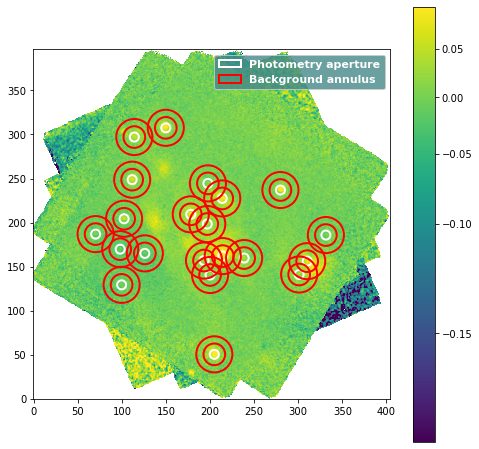

In [93]:
radii = [4,5,6,7,8,9,10,12] #aperture radii to use in photoemtry - units are pixels
r_in = 12  #inner radius for background annulus - units are pixels
r_out = 20  #outer radius for background annulus - units are pixels

if combTab is not None:
    CombPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesAll,radii,r_in,r_out,plot=True)

    #display the photometry table
    #CombPhotTable
else:
    print('No sources found in Combined Source List')

In [94]:
#merge Tables
mtComb = join(combTab, CombPhotTable, keys='id')

#add shape parameters to table
mtComb=fitshapes(data_bkgsub,mtComb) #optional plot=True for diagnostic plots

#show table - optional
mtComb

sky_centroid,type,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5pix,aperture_sum_err_5pix,aperture_sum_6pix,aperture_sum_err_6pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_9pix,aperture_sum_err_9pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5pix,aper_snr_5pix,aper_area_5pix,aper_sum_bkgsub_6pix,aper_snr_6pix,aper_area_6pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_9pix,aper_snr_9pix,aper_area_9pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,pix2,pix2,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.0720888370247,-29.411830768481092",110,1,102.44025201489848,204.36006168446312,"266.0720888370247,-29.411830768481092",1.3625615028916942,0.9948894474610483,1.3806687292185416,1.2430733462375534,1.2331890827288832,1.4910590497859497,0.9606343332270623,1.7390425753118597,0.6309485913865966,1.9872501734818762,0.12787831961394203,2.2371597555902465,-0.44212037909192,2.4891616975529454,-1.5287570903733299,2.996433390524816,842.38874909523,-0.005135329454965479,-0.006082320747650508,0.008953143351820333,546.9053000000002,433.9075595134235,1.6329329876267102,20.65025993176878,52.64929681845187,1.8031241741170043,21.39376155350964,82.26452627883106,1.8415249233826698,19.883782992276966,118.46091784151673,1.7886470052280499,17.09704022150745,161.23847150650894,1.7124345303266615,14.358816971915122,210.5971872738075,1.4966339610849615,10.220287051720502,266.53706514341263,1.2477014005019311,6.614341357761514,329.0581051153242,0.9045862722418159,2.9845489000386705,473.8436713660669,FieldN9,37,10.69063408782106,10.797316847699706,9.530819210971787,4.2856863697239955,3.794105917127947,-21.258649316685776,17.8449526534307,14.917394716592637,0.35318361140553783
"266.05357240910206,-29.410767826256542",110,2,178.04880381073755,209.3533730139019,"266.05357240910206,-29.410767826256542",3.65848033106907,0.9976078266266316,5.152255858220276,1.2464853682488435,6.843961515650324,1.4954202365940712,8.658142726482474,1.7444540159350492,10.526327103120085,1.9934527554077286,12.32152254348642,2.2423717517245043,14.075187629443963,2.491418133523973,17.777907587295367,2.9900769396880764,842.38874909523,0.01623003641620741,0.0165098070684751,0.01003886507289386,557.6466500000002,530.067716790538,2.803980326417883,41.709339931743784,52.64929681845187,3.817099600952797,58.09345100086713,82.26452627883106,4.921336505185154,76.19198895968555,118.46091784151673,6.041236462238213,94.56799581862772,161.23847150650894,7.108327084515338,111.93369529819728,210.5971872738075,7.995616269939786,125.9017768647587,266.53706514341263,8.734562600374044,137.06775055774312,329.0581051153242,10.087407545434687,157.02428272603657,473.8436713660669,FieldN9,37,11.090447479769377,9.632786102960692,8.198486135583172,3.6384998865123936,3.317238076557672,-52.78180452195819,11.82159264837775,12.421157232336993,1.049136868851778
"266.0448293059101,-29.406918931268958",210,3,213.75044980757676,227.3959829327285,"266.0448293059101,-29.406918931268

In [95]:
#write out catalog - May want some additional pre-processing before we get here but go ahead and print for now...
mtComb.write(field.name+'_'+str(wavelength)+'um_CombCat.fits', overwrite=True)

## Testing shape fitting routine

In [96]:
mtComb

sky_centroid,type,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5pix,aperture_sum_err_5pix,aperture_sum_6pix,aperture_sum_err_6pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_9pix,aperture_sum_err_9pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5pix,aper_snr_5pix,aper_area_5pix,aper_sum_bkgsub_6pix,aper_snr_6pix,aper_area_6pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_9pix,aper_snr_9pix,aper_area_9pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,pix2,pix2,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.0720888370247,-29.411830768481092",110,1,102.44025201489848,204.36006168446312,"266.0720888370247,-29.411830768481092",1.3625615028916942,0.9948894474610483,1.3806687292185416,1.2430733462375534,1.2331890827288832,1.4910590497859497,0.9606343332270623,1.7390425753118597,0.6309485913865966,1.9872501734818762,0.12787831961394203,2.2371597555902465,-0.44212037909192,2.4891616975529454,-1.5287570903733299,2.996433390524816,842.38874909523,-0.005135329454965479,-0.006082320747650508,0.008953143351820333,546.9053000000002,433.9075595134235,1.6329329876267102,20.65025993176878,52.64929681845187,1.8031241741170043,21.39376155350964,82.26452627883106,1.8415249233826698,19.883782992276966,118.46091784151673,1.7886470052280499,17.09704022150745,161.23847150650894,1.7124345303266615,14.358816971915122,210.5971872738075,1.4966339610849615,10.220287051720502,266.53706514341263,1.2477014005019311,6.614341357761514,329.0581051153242,0.9045862722418159,2.9845489000386705,473.8436713660669,FieldN9,37,10.69063408782106,10.797316847699706,9.530819210971787,4.2856863697239955,3.794105917127947,-21.258649316685776,17.8449526534307,14.917394716592637,0.35318361140553783
"266.05357240910206,-29.410767826256542",110,2,178.04880381073755,209.3533730139019,"266.05357240910206,-29.410767826256542",3.65848033106907,0.9976078266266316,5.152255858220276,1.2464853682488435,6.843961515650324,1.4954202365940712,8.658142726482474,1.7444540159350492,10.526327103120085,1.9934527554077286,12.32152254348642,2.2423717517245043,14.075187629443963,2.491418133523973,17.777907587295367,2.9900769396880764,842.38874909523,0.01623003641620741,0.0165098070684751,0.01003886507289386,557.6466500000002,530.067716790538,2.803980326417883,41.709339931743784,52.64929681845187,3.817099600952797,58.09345100086713,82.26452627883106,4.921336505185154,76.19198895968555,118.46091784151673,6.041236462238213,94.56799581862772,161.23847150650894,7.108327084515338,111.93369529819728,210.5971872738075,7.995616269939786,125.9017768647587,266.53706514341263,8.734562600374044,137.06775055774312,329.0581051153242,10.087407545434687,157.02428272603657,473.8436713660669,FieldN9,37,11.090447479769377,9.632786102960692,8.198486135583172,3.6384998865123936,3.317238076557672,-52.78180452195819,11.82159264837775,12.421157232336993,1.049136868851778
"266.0448293059101,-29.406918931268958",210,3,213.75044980757676,227.3959829327285,"266.0448293059101,-29.406918931268

In [83]:
def fitshapes2(image,tab,plot=False):
    columns = ['xcentroid', 'ycentroid','fwhm' ,'semimajor_sigma','semiminor_sigma', 'orientation','covar_sigx2','covar_sigy2']
    
    #initialize table with correct column formatting by creating dummy table
    from photutils.datasets import make_4gaussians_image
    data = make_4gaussians_image()[43:79, 76:104]
    cat = data_properties(data)
    tbl = cat.to_table(columns=columns)
    tbl.remove_row(0) #remove entry from dummy table
    
    #fix keywords in table if they don't match what is expected
    if 'xcentroid' not in tab.columns:
        tab.rename_column('xcenter', 'xcentroid')
        tab.rename_column('ycenter', 'ycentroid')
    
    #loop through sources and fit shapes
    for source in tab:
        #create data cutout around source centroid position
        spos=(np.int64(source['xcentroid']),np.int64(source['ycentroid']))
        cutout=Cutout2D(image,spos,21,copy=True)
        
        #do addtional bkg subtraciton here? - think not for now...
        mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
        c1 = cutout.data - median
        
        #get shape fitting results and store to table
        cat = data_properties(c1,background=std)
        temp = cat.to_table(columns=columns)
        tbl=vstack([tbl,temp])

        #optional plots for visual diagnostics
        if plot==True:
            position = (cat.xcentroid, cat.ycentroid)
            r = 1.0  # approximate isophotal extent
            a = cat.semimajor_sigma.value * r
            b = cat.semiminor_sigma.value * r
            theta = cat.orientation.to(u.rad).value
            apertures = EllipticalAperture(position, a, b, theta=theta)
            plt.imshow(c1, origin='lower', cmap='viridis',interpolation=None)
            apertures.plot(color='r')
            plt.show()
            
    tbl['fit_dist']=np.sqrt((tbl['xcentroid']-10.5)**2+(tbl['ycentroid']-10.5)**2)
            
    return tbl 
    
    #if needed, rename duplicate columns from seg table
    #if 'fwhm' in tab.columns:
    #    tab.rename_column('fwhm', 'fwhm_seg')
    #    print('this already has FWHM column!')
    #if 'semimajor_sigma' in tab.columns:
    #    tab.rename_column('semimajor_sigma', 'semimajor_sigma_seg')
    #if 'semiminor_sigma' in tab.columns:
    #    tab.rename_column('semiminor_sigma', 'semiminor_sigma_seg')        
    #if 'orientation' in tab.columns:
    #    tab.rename_column('orientation', 'orientation_seg')        
        
    #add fitted shape parameters to table
    #tab['fit_x_cent']=tbl['xcentroid']
    #tab['fit_y_cent']=tbl['ycentroid']        
    #tab['fwhm']=tbl['fwhm']    
    #tab['semimajor_sigma']=tbl['semimajor_sigma']
    #tab['semiminor_sigma']=tbl['semiminor_sigma']
    #tab['orientation']=tbl['orientation']

    #return input table with new columns from shape fitting
    #return tab


In [84]:
testsource=mtComb

In [85]:
testsource

sky_centroid,type,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5pix,aperture_sum_err_5pix,aperture_sum_6pix,aperture_sum_err_6pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_9pix,aperture_sum_err_9pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5pix,aper_snr_5pix,aper_area_5pix,aper_sum_bkgsub_6pix,aper_snr_6pix,aper_area_6pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_9pix,aper_snr_9pix,aper_area_9pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,pix2,pix2
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64
"266.0720888370247,-29.411830768481092",110,1,102.44025201489848,204.36006168446312,"266.0720888370247,-29.411830768481092",1.3625615028916942,0.9948894474610483,1.3806687292185416,1.2430733462375534,1.2331890827288832,1.4910590497859497,0.9606343332270623,1.7390425753118597,0.6309485913865966,1.9872501734818762,0.12787831961394203,2.2371597555902465,-0.44212037909192,2.4891616975529454,-1.5287570903733299,2.996433390524816,842.38874909523,-0.005135329454965479,-0.006082320747650508,0.008953143351820333,546.9053000000002,433.9075595134235,1.6329329876267102,20.65025993176878,52.64929681845187,1.8031241741170043,21.39376155350964,82.26452627883106,1.8415249233826698,19.883782992276966,118.46091784151673,1.7886470052280499,17.09704022150745,161.23847150650894,1.7124345303266615,14.358816971915122,210.5971872738075,1.4966339610849615,10.220287051720502,266.53706514341263,1.2477014005019311,6.614341357761514,329.0581051153242,0.9045862722418159,2.9845489000386705,473.8436713660669,FieldN9,37,8.410882552908348,8.584775625666927,7.031418957045795,3.2627185965300662,2.6807994250744454,-14.746825036389486,10.421230059807497,7.410788137815102
"266.05357240910206,-29.410767826256542",110,2,178.04880381073755,209.3533730139019,"266.05357240910206,-29.410767826256542",3.65848033106907,0.9976078266266316,5.152255858220276,1.2464853682488435,6.843961515650324,1.4954202365940712,8.658142726482474,1.7444540159350492,10.526327103120085,1.9934527554077286,12.32152254348642,2.2423717517245043,14.075187629443963,2.491418133523973,17.777907587295367,2.9900769396880764,842.38874909523,0.01623003641620741,0.0165098070684751,0.01003886507289386,557.6466500000002,530.067716790538,2.803980326417883,41.709339931743784,52.64929681845187,3.817099600952797,58.09345100086713,82.26452627883106,4.921336505185154,76.19198895968555,118.46091784151673,6.041236462238213,94.56799581862772,161.23847150650894,7.108327084515338,111.93369529819728,210.5971872738075,7.995616269939786,125.9017768647587,266.53706514341263,8.734562600374044,137.06775055774312,329.0581051153242,10.087407545434687,157.02428272603657,473.8436713660669,FieldN9,37,8.849549801171348,7.832798043775939,6.678679761893323,2.940813014928068,2.727523883818044,-35.90808599030313,8.232527392211002,7.855240333357176
"266.0448293059101,-29.406918931268958",210,3,213.75044980757676,227.3959829327285,"266.0448293059101,-29.406918931268958",4.207702761894002,0.9912499300151629,5.86180374140219

(0.00041821439700559553, 0.0, 0.00919491141180235)


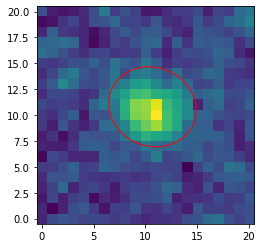

(0.0014442755430182407, -3.469446951953614e-18, 0.015139722817484273)


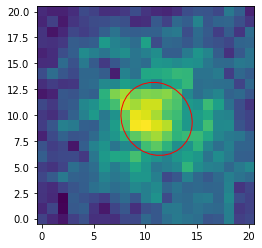

(0.003915565532467361, 3.469446951953614e-18, 0.021670607506301412)


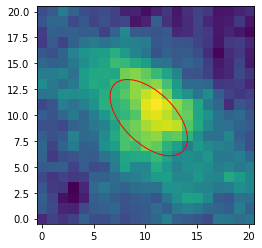

(0.0007527587948643248, 0.0, 0.010409449105694907)


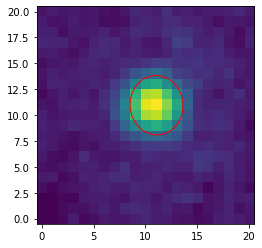

(0.0019558467054740874, 0.0, 0.013388555938120258)


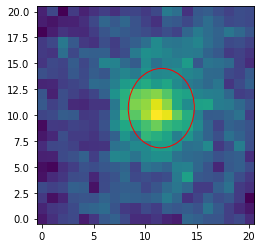

(0.002804654543740506, 0.0, 0.01606916029161895)


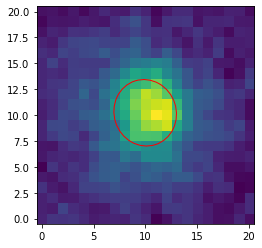

(-0.0005664972916807164, 0.0, 0.009289582908821965)


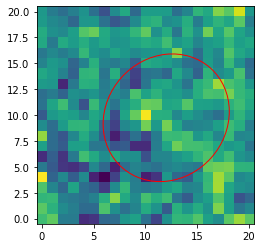

(-3.993459833584981e-05, 0.0, 0.009161159896423599)


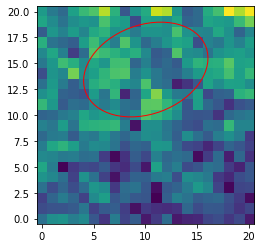

(0.0016782266223581014, 0.0, 0.012156819664120879)


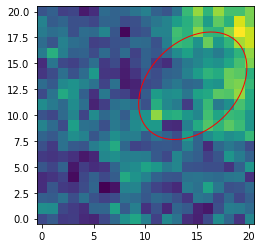

(0.003460464024096859, 0.0, 0.026248550337117257)


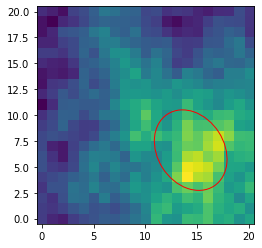

(0.0013778061355912672, 0.0, 0.012808063297583208)


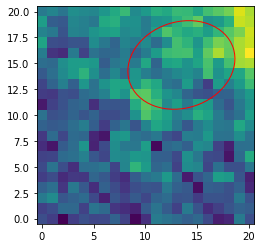

(-0.0006650069024255755, -1.734723475976807e-18, 0.012144081438606605)


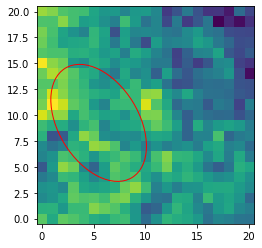

(0.00032373944405308437, 0.0, 0.008638548386577993)


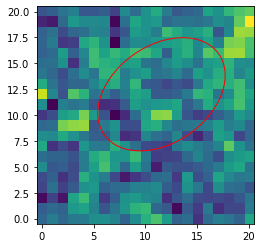

(-7.014526054343854e-05, 0.0, 0.007911770044228009)


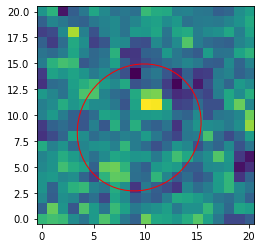

(0.0003998418681823528, 0.0, 0.009452687166649603)


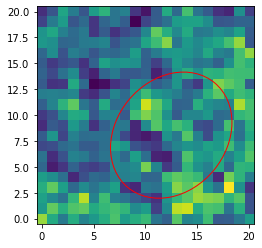

(-2.1896497664001194e-05, 0.0, 0.010036103112265249)


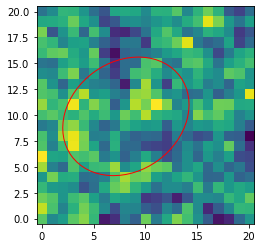

(0.0007887547382684633, 0.0, 0.009196429398713285)


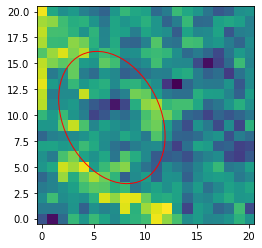

(0.000905085283790151, 0.0, 0.010705303233297783)


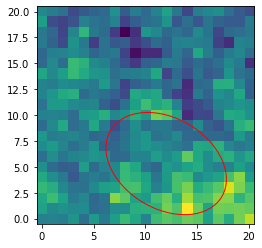

(0.0031874585251920645, 0.0, 0.023823643207990863)


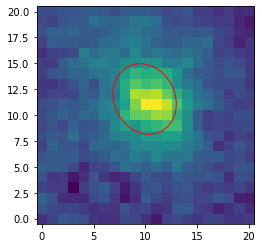

(0.004715737400928976, 6.938893903907228e-18, 0.0373719900912878)


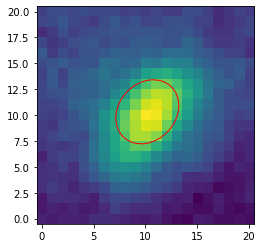

(0.0013434753670080303, 0.0, 0.014257092221293751)


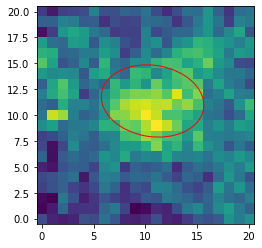

In [86]:
#bkg sub with cutout 17x17
rtab=fitshapes2(data_bkgsub,testsource,plot=True)

In [87]:
rtab

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist
,,pix,pix,pix,deg,pix2,pix2,
float64,float64,float64,float64,float64,float64,float64,float64,float64
10.69063408782106,10.797316847699706,9.530819210971787,4.2856863697239955,3.794105917127947,-21.258649316685776,17.8449526534307,14.917394716592637,0.35318361140553783
11.090447479769377,9.632786102960692,8.198486135583172,3.6384998865123936,3.317238076557672,-52.78180452195819,11.82159264837775,12.421157232336993,1.049136868851778
10.334848986972109,9.749796367092488,8.739227602018163,4.61930605575836,2.4916149505810585,-44.308911351951465,13.955541775943228,13.590591722781673,0.7681668750550026
11.085445469636369,10.953764095349259,6.393347042804446,2.868577936616122,2.5522068101186024,-85.46836659278028,6.524465361731417,8.218033618325164,0.7407079398426074
11.544906473140626,10.670536600822379,8.302641654496913,3.8352591107810676,3.186443391060115,87.96136186033048,10.15918669976587,14.703447231494001,1.058731443677401
9.988723402024043,10.221863871698439,7.337160459804261,3.2280636876358395,2.9993480100771683,-72.30894602619932,9.12761704705675,10.288866609930214,0.5820339040850208
12.019954291298259,9.739718229043673,14.43057300210242,6.426259212942448,5.814672364450269,48.3769187398971,37.113396559871916,37.993825617957455,1.6994968134375776
10.046178546758012,14.399553742942024,12.569799334974784,6.206755323231097,4.296811642477432,20.518277652279444,36.059198860933066,20.927203072454102,3.9258722986765395


In [82]:
np.median(rtab['ycentroid'])

10.221863871698439

(0.013535747304558754, 0.0, 0.048259541392326355)


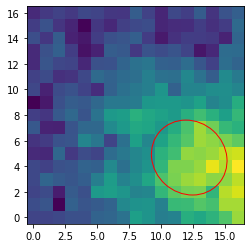

(-9.833320655161515e-05, 0.0, 0.016577130183577538)


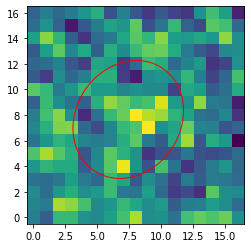

(0.010327734984457493, 0.0, 0.04472045600414276)


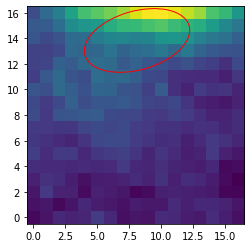

(0.018253445625305176, 0.0, 0.05218310281634331)


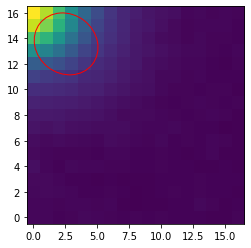

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2
,,pix,pix,pix,deg,pix2,pix2
float64,float64,float64,float64,float64,float64,float64,float64
12.186855445251517,4.679447824441587,6.929120487468228,3.0717579169627003,2.8073525280903713,-42.03612196329519,8.738730853570308,8.578194063828118
7.419666193105631,7.658171699844464,10.520580582634587,4.816237102904387,4.089520191768065,56.702755487310846,18.67470845696184,21.24560677330971
8.107409113206279,13.834412355908762,8.015666718784804,4.230331493412391,2.297371068420981,15.788496341455403,16.961592298042532,6.212026072131932
2.5620316585739564,13.566399910276253,5.78479880590405,2.5993352647880363,2.3049958405568844,-37.913768686446474,6.211493771489227,5.858055872266004


In [104]:
#bkg sub with cutout 13x13
fitshapes2(data_bkgsub,testsource,plot=True)

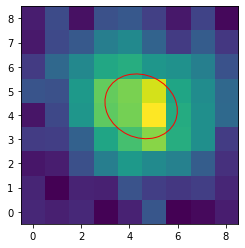

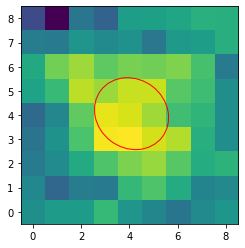

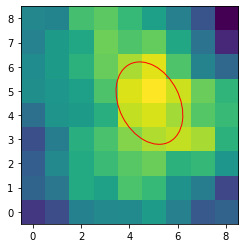

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,pix,pix,pix,deg
float64,float64,float64,float64,float64,float64
4.490483010669817,4.362329484005431,3.347642081156051,1.540947531100895,1.2912962639928434,-25.200267749430008
4.093481732508456,4.0586688592696945,3.5579666039398696,1.595826160606568,1.4209692356347339,-37.438595008044224
4.833763604371667,4.495415995003617,3.655082523020338,1.8043846200281632,1.250065397943882,-63.062605119559045


In [33]:
#bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

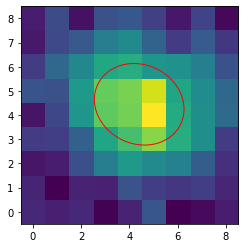

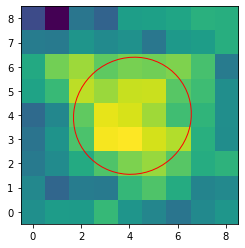

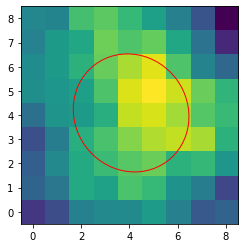

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,pix,pix,pix,deg
float64,float64,float64,float64,float64,float64
4.410352724150449,4.446561292209267,4.176804166152969,1.9029743703510267,1.6342864666483385,-25.615003890609806
4.128576719435332,3.9719936363713053,5.723627870826212,2.472983490583185,2.3874661767073775,40.273848564947166
4.074458240595917,4.089426855138581,5.694939480095021,2.4959693935184544,2.3382962279865565,-53.991394674835945


In [29]:
#no bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

## Do Photometry - Only Segment Map Sources (optional)

In [26]:
#get seg table from detection step
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None

#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']

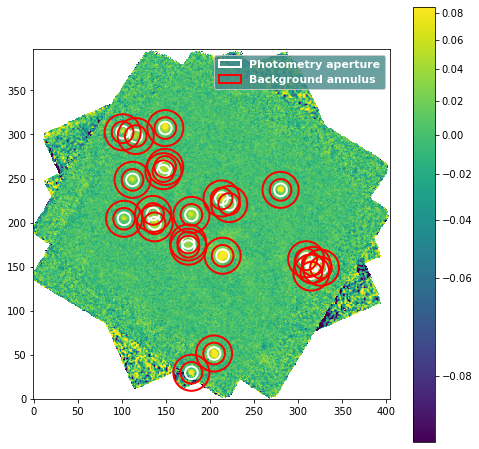

In [27]:
if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    #SegPhotTable
else:
    print('No sources found in segmentation map')

In [28]:
#fix id keywords in Seg table so they can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [37]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')

#add shape parameters to table
mtSeg=fitshapes(data_bkgsub,mtSeg) #optional plot=True for diagnostic plots

#display seg table
mtSeg

this already has FWHM column!


id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64
1,178.74334802094756,29.695390117681253,"266.05340503129935,-29.44909486681929",-0.0013619890502151399,0.0013071731744726189,0.03398650253628809,26.0,1.443840374948312,1.2160638049846695,-32.16204489596808,0.5353791657721712,0.17712248538784145,0.6205307607012144,0.5390987666544573,0.15775744598622732,1.1873064299997926,3.1432597199337975,3.368134646550717,1.3656426555364503,1.1141335679763515,2.60928748919837,1.0574602442740115,0.0011001415188336455,0.0012389231085403714,0.0007102264825112266,2.5155369672504873,178.74334802094324,29.69539011770604,"266.05340503129935,-29.44909486681929",3.620989050815081,1.539508711604046,3.6098120030926006,3.0545273225226515,-1.7956097771389976,5.919878166251133,842.3892863976475,-0.0030094404963086118,-0.005956806472558656,0.021536970474176933,105.13515000000002,73.33971114438987,3.77943407782393,46.89501562371681,52.64933039985298,4.095049898307202,37.783501424863985,161.23857434954976,-0.36960453405935056,-0.21076114147937242,473.84397359867694,FieldN9,37,4.584377197712468,4.5554895815225835,4.535910080105189,2.1362692003895267,1.6902748479416019,-46.94462228691341
2,204.44622686243497,51.53185474997358,"266.0471081083462,-29.444436612944074",-0.0052847919589830376,0.012450626299788126,1.494075155974575,120.0,3.1353880809381875,2.349310254754962,-65.50082657484333,0.16751964271530206,0.059968599526799615,0.11538669662317141,0.6622437111306206,0.25071149276934523,1.3345994104406678,6.523726466854521,13.38069941948893,3.5782239562439466,1.7587153855765443,8.86639773491292,1.8218148444296434,0.012449561647210188,0.013218304604890495,0.0026643376472243047,6.058771644800698,204.44622686241246,51.53185475002854,"266.0471081083462,-29.444436612944074",5.505680573630593,1.2118995257964638,9.929218262368778,2.118321283515523,13.15582883156841,3.6948254072154443,842.3892863976475,-0.0005571220182018139,-0.000996490121957799,0.00975187290097469,210.27030000000008,213.10771617345213,5.535012674839932,92.99084341525621,52.64933039985298,10.019047822322381,168.8111285252257,161.23857434954976,13.419817742452473,220.36449439307384,473.84397359867694,FieldN9,37,4.333721141079679,4.044061445066242,5.370293165155285,2.360878004902144,2.1972946657820014,-55.63881600516043
3,325.7005678316298,148.87073032795735,"266.0174095719637,-29.42366789441942",-0.0001871980188086556,0.027533291104583607,0.16519974662750164,6.0,1.2245560636068737,0.355653600083195,28.25368226487449,2.28900713278205,-6.036949041419875,6.283660728191581,0.9568948072663164,0.7095652778561778,3.443114489268276,2.123276765411838,3.2407826054277624,1.849319086588444,3.648138275231959,0.2842096

In [30]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)

## Do Photometry - Only DAO Sources (optional)

In [31]:
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']

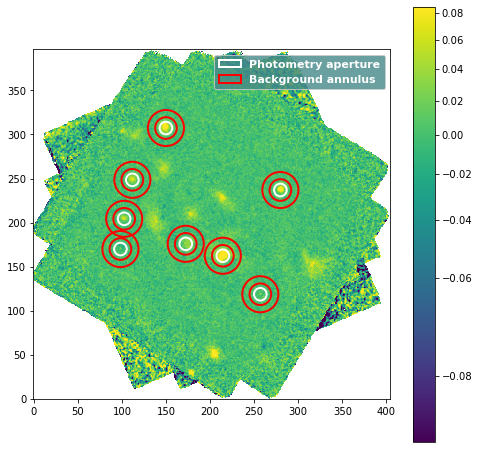

In [32]:
if daoTab is not None:
    DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

    #display the photometry table
    #DaoPhotTable
else:
    print('No sources found by DAOfind map')

In [33]:
#merge Tables
mtDao = join(daoTab, DaoPhotTable, keys='id')

#add shape parameters to table
mtDao=fitshapes(data_bkgsub,mtDao) #optional plot=True for diagnostic plots

#optional - show Dao table
#mtDao

In [34]:
#write out the resulting tables to file
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)